In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

pd.set_option('display.float_format', '{:.3f}'.format)

In [3]:
# load physiological signal data
df_signal = pd.read_csv('final_merged.csv')
df_signal.head()

C:\Users\User\AppData\Local\Temp\ipykernel_25008\3512862138.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_signal = pd.read_csv('final_merged.csv')


,X,Y,Z,Timestamp,Nurse ID,BVP,EDA,HR,TEMP
0,-15.000,15.000,58.000,1586788313.000,CE,-0.000,0.000,NaN,31.730
1,-14.000,15.000,59.000,1586788313.250,CE,-0.050,0.059,NaN,31.730
2,-14.000,16.000,59.000,1586788313.500,CE,6.200,0.079,NaN,31.730
3,-14.000,16.000,59.000,1586788313.750,CE,22.900,0.081,NaN,31.730
4,-13.000,16.000,58.000,1586788314.000,CE,93.760,0.081,NaN,31.730


In [4]:
# load survey data
df_survey = pd.read_csv('Preprocessed_SurveyResults.csv')

# convert timestamp columns to float64 for comparison with signal data
df_survey["start_timestamp"] = df_survey["start_timestamp"].astype("float64")
df_survey["end_timestamp"] = df_survey["end_timestamp"].astype("float64")

# convert stress_level to int
df_survey["stress_level"] = df_survey["stress_level"].astype("int")

df_survey.head()

,id,stress_level,covid_related,treating_a_covid_patient,patient_in_crisis,patient_or_patients_family,doctors_or_colleagues,administration_lab_pharmacy_radiology_or_other_ancilliary_services,increased_workload,technology_related_stress,...,saftey_physical_or_physiological_threats,work_environment_physical_or_others:_work_processes_or_procedures,description,start_timestamp,end_timestamp,duration_seconds,na_entry_before_count,na_entry_before_duration,na_entry_after_count,na_entry_after_duration
0,5C,1,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,...,0.000,0.000,NaN,1586903460.000,1586905080.000,1620,0,0,0,0
1,5C,1,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,...,0.000,0.000,NaN,1586955600.000,1586959200.000,3600,0,0,0,0
2,E4,2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1.000,Was trying to get organized after being pulled...,1587215700.000,1587216240.000,540,0,0,0,0
3,E4,2,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,...,0.000,1.000,Was assessing a COVID patient who required a l...,1587220320.000,1587220680.000,360,0,0,0,0
4,7A,2,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,...,0.000,1.000,NaN,1587235920.000,1587236580.000,660,0,0,0,0


#### Merging the signal and survey results with matching Timestamp ranges for each nurseID

In [64]:
# temporary list to store the updated DataFrames
inter_dfs = []

# iterate through each unique Nurse ID
for nurse_id in df_signal['Nurse ID'].unique():
    
    # filter data for the current Nurse ID
    signal_nurse = df_signal[df_signal['Nurse ID'] == nurse_id].copy()
    survey_nurse = df_survey[df_survey['id'] == nurse_id]

    # merge stress information by checking if the timestamp lies within the time range
    for _, survey_row in survey_nurse.iterrows():
        mask = (signal_nurse['Timestamp'] >= survey_row['start_timestamp']) & \
               (signal_nurse['Timestamp'] <= survey_row['end_timestamp'])

        # add stress_level and duration_seconds to matching rows
        signal_nurse.loc[mask, 'stress_level'] = survey_row['stress_level']
        signal_nurse.loc[mask, 'duration_seconds'] = survey_row['duration_seconds']

    # collect the updated DataFrame
    inter_dfs.append(signal_nurse)

# concatenate all updated DataFrames into a final DataFrame
merged_df = pd.concat(inter_dfs)

# reset the index
merged_df.reset_index(drop=True, inplace=True)

merged_df.head()

,X,Y,Z,Timestamp,Nurse ID,BVP,EDA,HR,TEMP,stress_level,duration_seconds
0,-15.000,15.000,58.000,1586788313.000,CE,-0.000,0.000,NaN,31.730,NaN,NaN
1,-14.000,15.000,59.000,1586788313.250,CE,-0.050,0.059,NaN,31.730,NaN,NaN
2,-14.000,16.000,59.000,1586788313.500,CE,6.200,0.079,NaN,31.730,NaN,NaN
3,-14.000,16.000,59.000,1586788313.750,CE,22.900,0.081,NaN,31.730,NaN,NaN
4,-13.000,16.000,58.000,1586788314.000,CE,93.760,0.081,NaN,31.730,NaN,NaN


In [65]:
merged_df.isnull().sum()

X                    9380931
Y                    9380931
Z                    9380931
Timestamp                  0
Nurse ID                   0
BVP                  9380841
EDA                  9381996
HR                   9448506
TEMP                 9388794
stress_level        25480056
duration_seconds    25480056
dtype: int64

#### Filter the null stress_level records since cannot fill them as they are personal responses

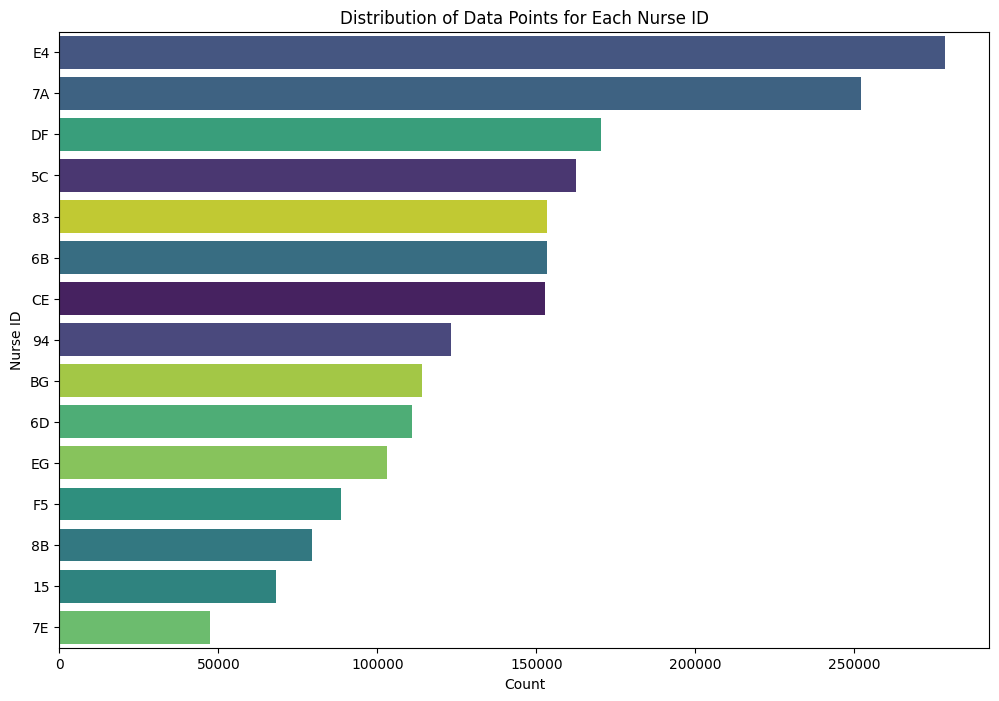

In [66]:
# filter the rows where stress_level is null
merged_df = merged_df.dropna(subset=['stress_level'])

# visualize distribution
plt.figure(figsize=(12, 8))
sns.countplot(y=merged_df['Nurse ID'], order=merged_df['Nurse ID'].value_counts().index, palette='viridis', hue= merged_df['Nurse ID'], legend=False)
plt.title('Distribution of Data Points for Each Nurse ID')
plt.xlabel('Count')
plt.ylabel('Nurse ID')
plt.show()

<Axes: >

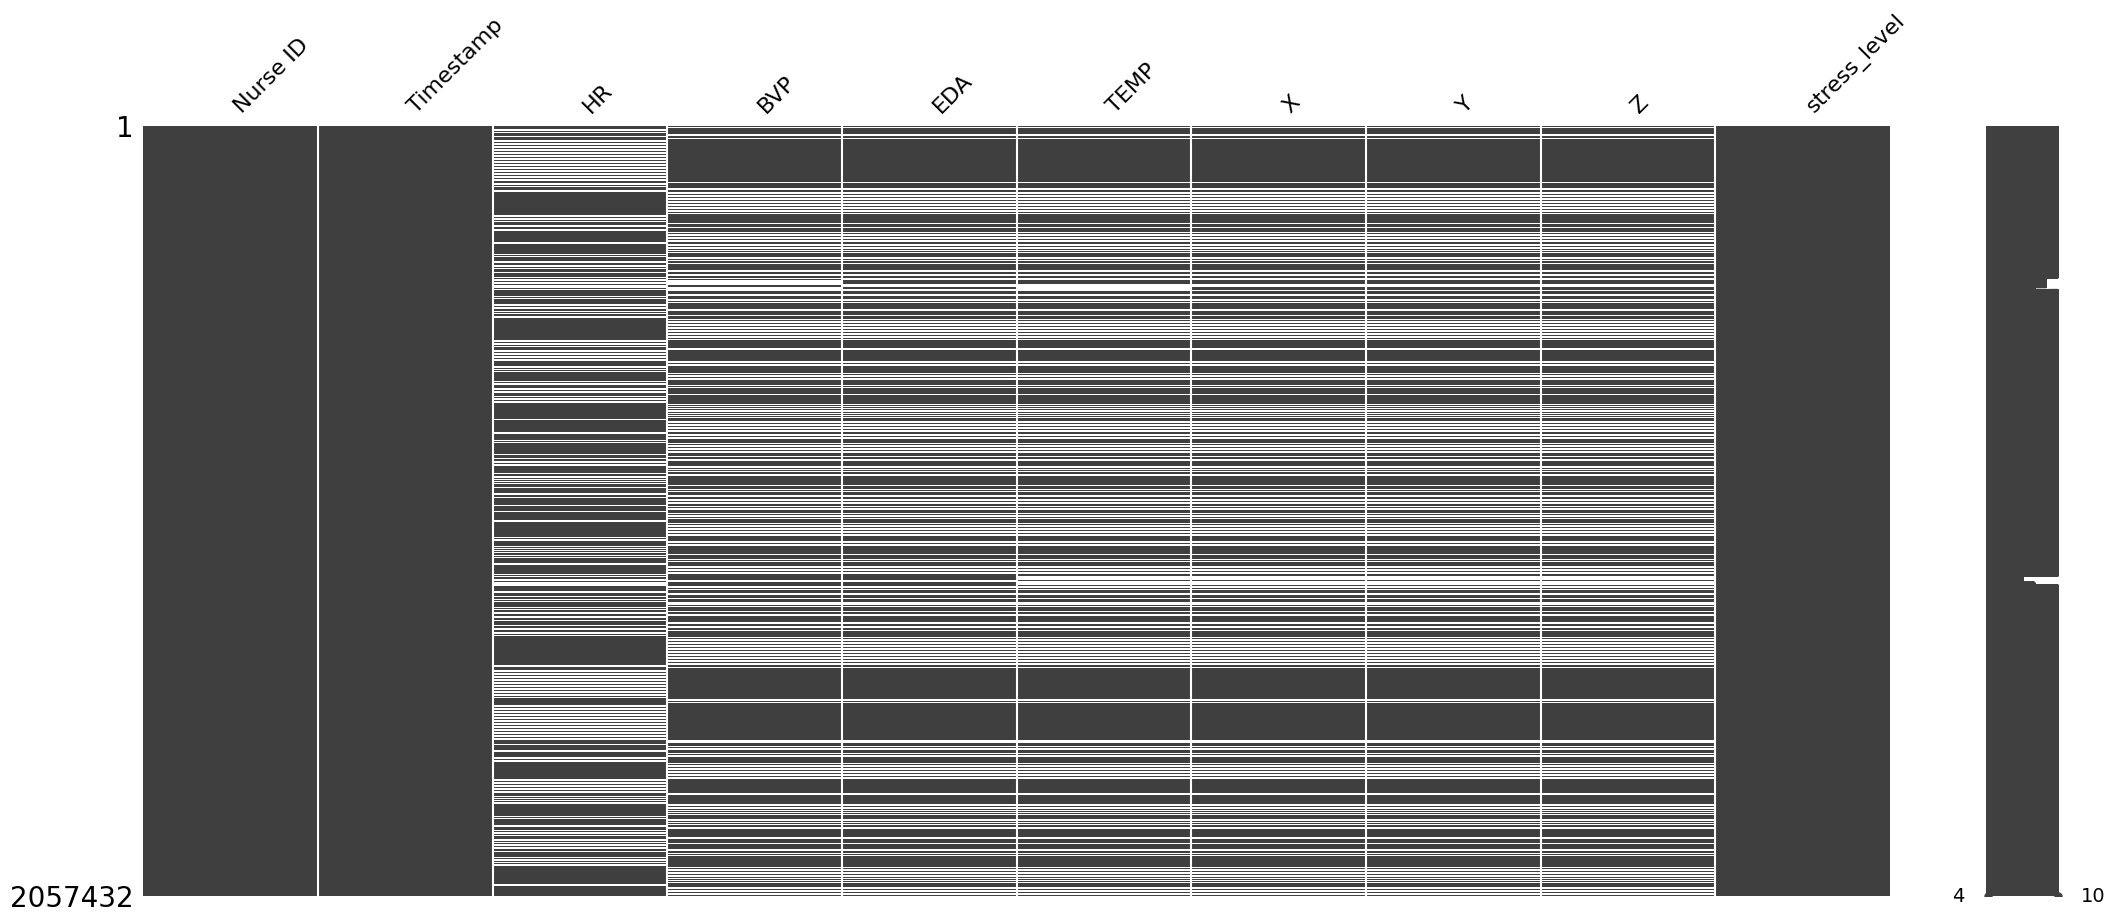

In [68]:
# visualize missing data patterns
msno.matrix(merged_df[["Nurse ID", "Timestamp", "HR", "BVP","EDA","TEMP","X","Y","Z","stress_level"]])

<Axes: >

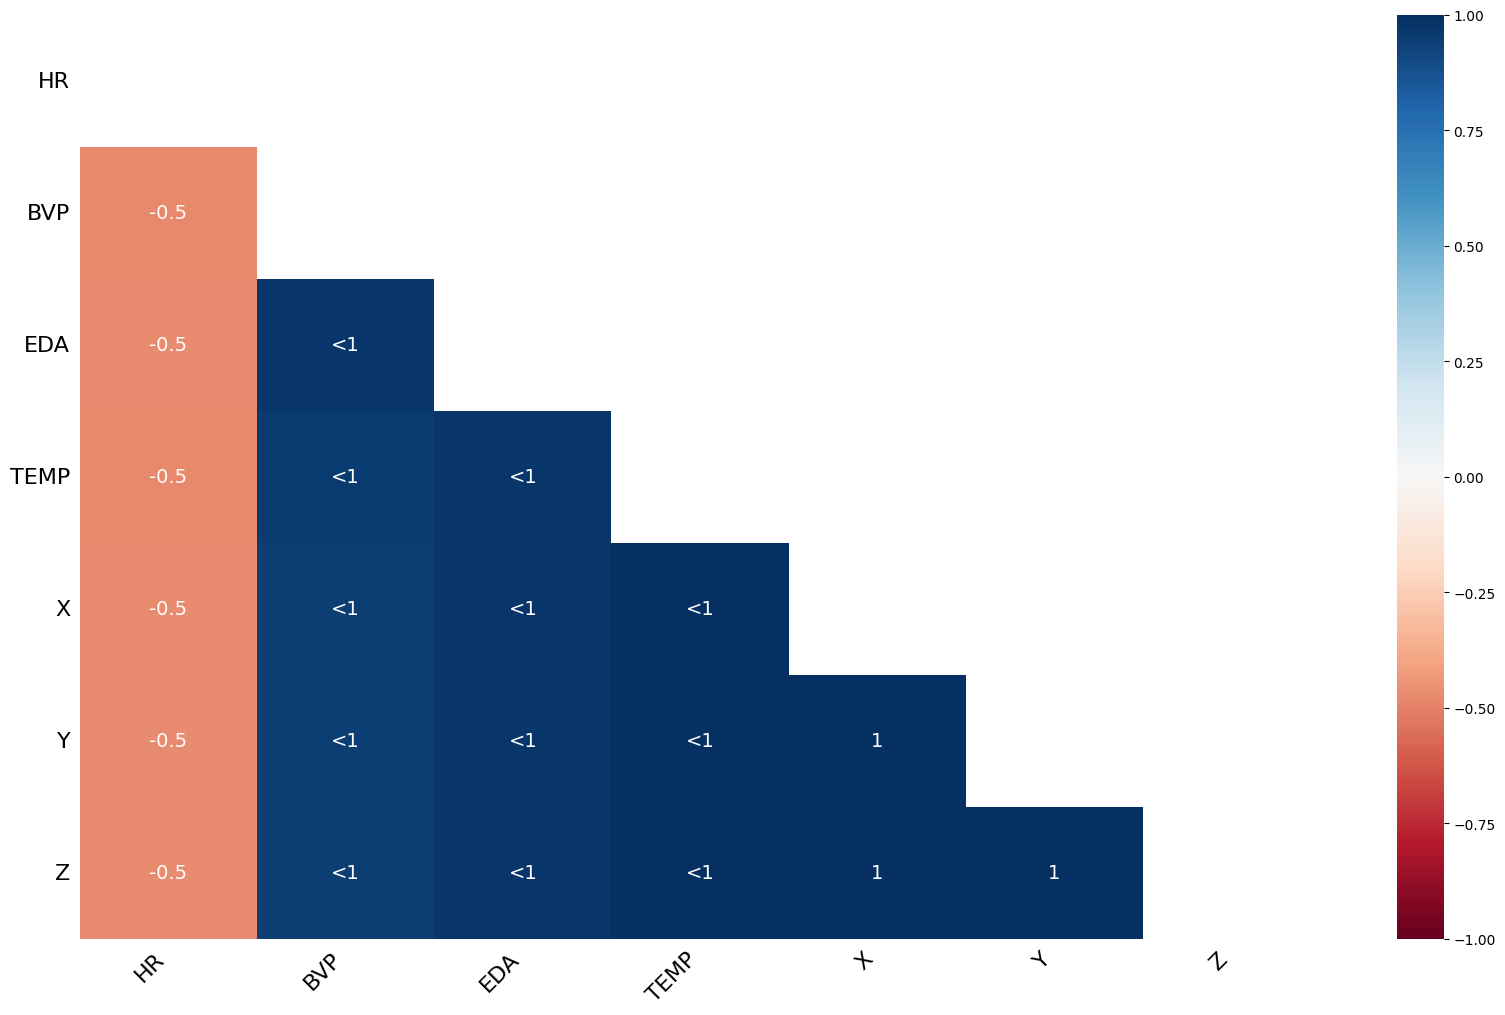

In [69]:
# Visualize missing data heatmap
msno.heatmap(merged_df[["Nurse ID", "Timestamp", "HR", "BVP","EDA","TEMP","X","Y","Z","stress_level"]])

#### How to read above missing value percentages and correlations

- A value near -1 means if one variable appears then the other variable is very likely to be missing.
- A value near 0 means there is no dependence between the occurrence of missing values of two variables.
- A value near 1 means if one variable appears then the other variable is very likely to be present.

##### Since HR (Heart Rate) has a higher missing value rate compared to others need to focus on it and other signal behaviors initially for cleaning the data

In [70]:
merged_df.isnull().sum()

X                   701187
Y                   701187
Z                   701187
Timestamp                0
Nurse ID                 0
BVP                 701185
EDA                 701190
HR                  701429
TEMP                701188
stress_level             0
duration_seconds         0
dtype: int64

In [71]:
# check where HR exists but other signals are missing
missing_signals = merged_df[(merged_df['HR'].notna()) & 
                              (merged_df[['BVP','EDA', 'TEMP','X','Y','Z']].isna().any(axis=1))]

print(missing_signals.groupby('Nurse ID').size())
print("Total number of rows: ", missing_signals.shape[0])

Nurse ID
15    24363
5C    54120
6B    51096
6D    36960
7A    84021
7E    15840
83    51119
8B    26485
94    43194
BG    38040
CE    50880
DF    56760
E4    92830
EG    34320
F5    29520
dtype: int64
Total number of rows:  689548


In [72]:
# calculate missingness ratio for each Nurse ID
missing_ratio = missing_signals.groupby('Nurse ID').size() / merged_df.groupby('Nurse ID').size()
print(missing_ratio.sort_values(ascending=False))

Nurse ID
15   0.358
94   0.351
6D   0.333
EG   0.333
CE   0.333
DF   0.333
5C   0.333
83   0.333
BG   0.333
7E   0.333
8B   0.333
F5   0.333
7A   0.333
6B   0.333
E4   0.333
dtype: float64


#### Around 30% data from each nurseID has NaN entries for most of the signals except HR. We have to drop these entries since it is a larger volume to imputate

In [73]:
# drop rows where HR is not null and BVP, EDA, TEMP, X, Y, Z contain null
filtered_df = merged_df.drop(merged_df[(merged_df['HR'].notna()) & 
                                           (merged_df[['BVP', 'EDA', 'TEMP','X','Y','Z']].isna().any(axis=1))].index)

row_count = filtered_df.shape[0]
print(f"Row count: {row_count}")

Row count: 1367884


In [74]:
filtered_df.isnull().sum()

X                    19565
Y                    19565
Z                    19565
Timestamp                0
Nurse ID                 0
BVP                  15362
EDA                  21391
HR                  701429
TEMP                 18022
stress_level             0
duration_seconds         0
dtype: int64

<Axes: >

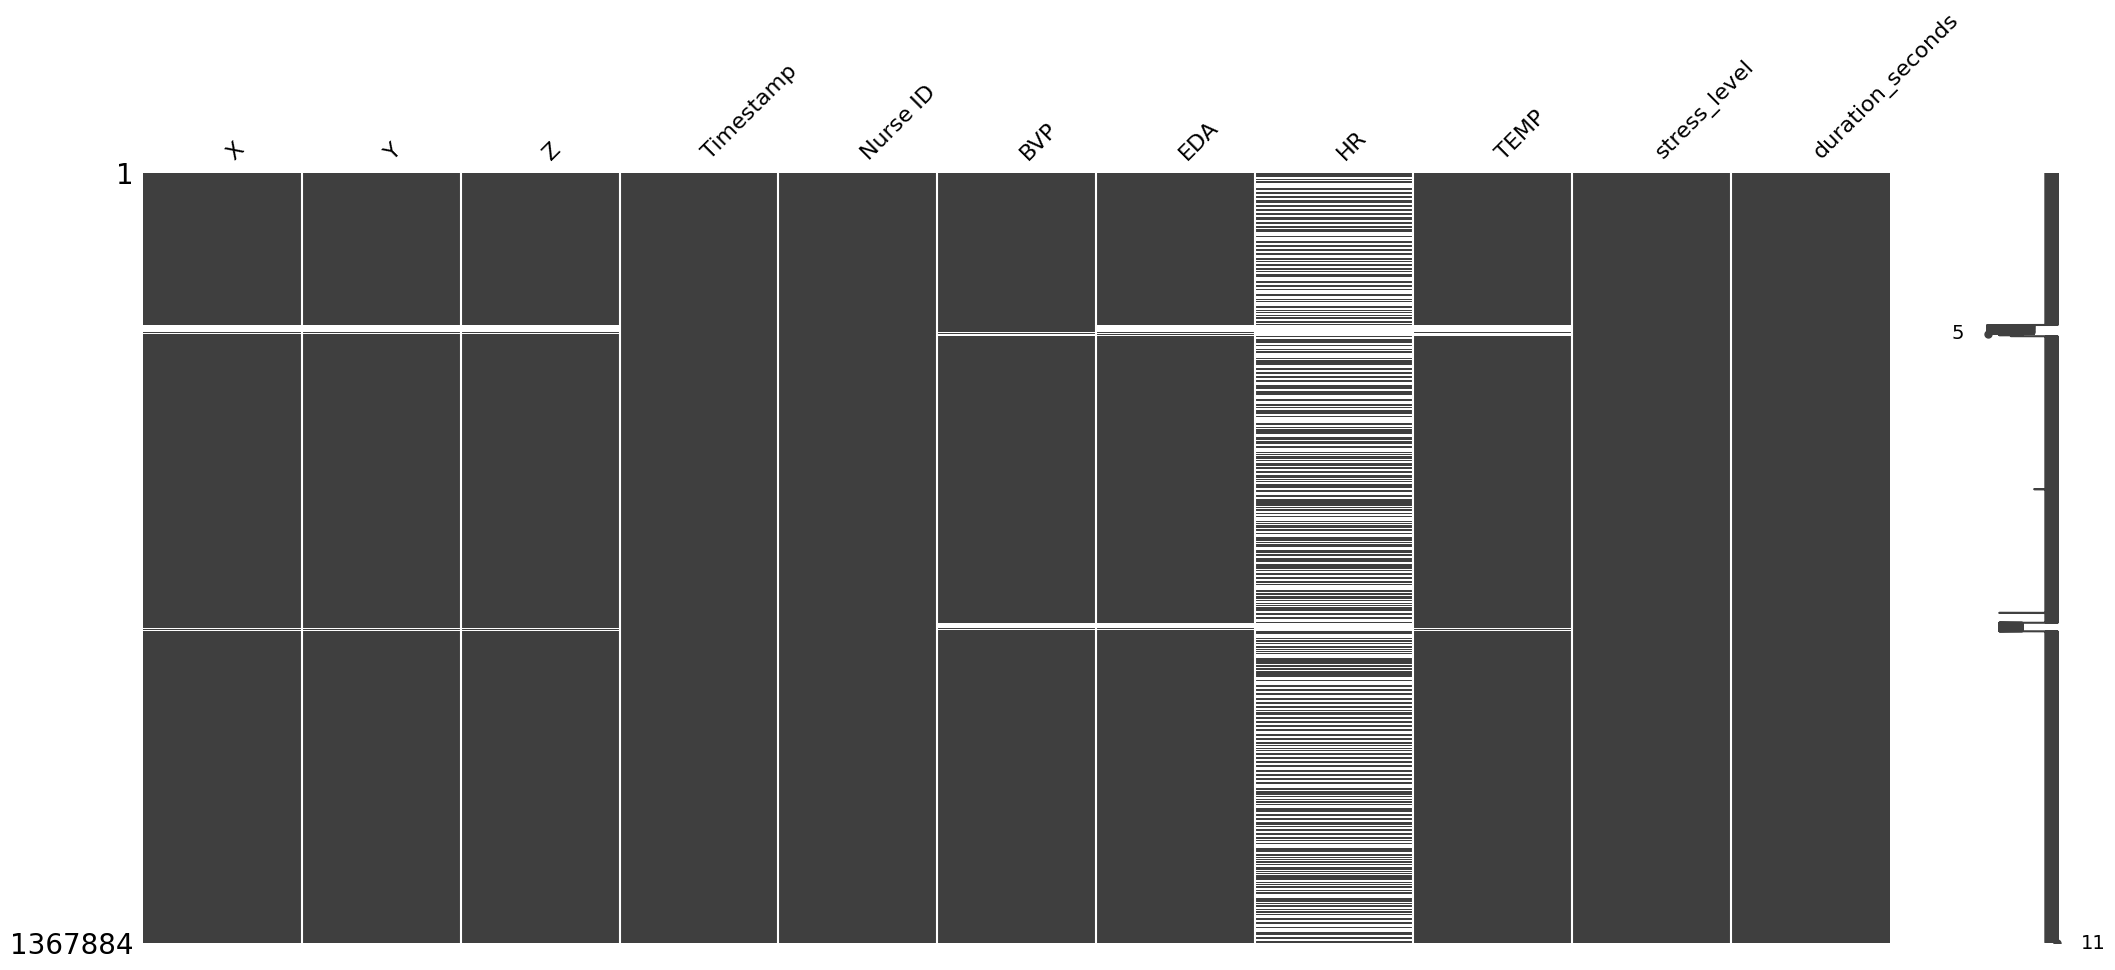

In [75]:
# visualize
msno.matrix(filtered_df)

##### pre-processing further since there still exists missing records in other physiological signals

In [78]:
# check where HR exists but other signals are missing
missing_signals = filtered_df[(filtered_df['HR'].isna()) & 
                              (filtered_df[['BVP','EDA', 'TEMP','X','Y','Z']].isna().any(axis=1))]

print(missing_signals.groupby('Nurse ID').size())
print("Total number of rows: ", missing_signals.shape[0])

Nurse ID
15    15123
7A        3
8B        1
94    19803
dtype: int64
Total number of rows:  34930


In [79]:
# drop rows where HR is null and BVP, EDA, TEMP, X, Y, Z also contain null records
filtered_df2 = filtered_df.drop(filtered_df[(filtered_df['HR'].isna()) & 
                                           (filtered_df[['BVP', 'EDA', 'TEMP','X','Y','Z']].isna().any(axis=1))].index)

row_count = filtered_df2.shape[0]
print(f"Row count: {row_count}")

Row count: 1332954


In [80]:
filtered_df2.isnull().sum()

X                        0
Y                        0
Z                        0
Timestamp                0
Nurse ID                 0
BVP                      0
EDA                      0
HR                  666499
TEMP                     0
stress_level             0
duration_seconds         0
dtype: int64

<Axes: >

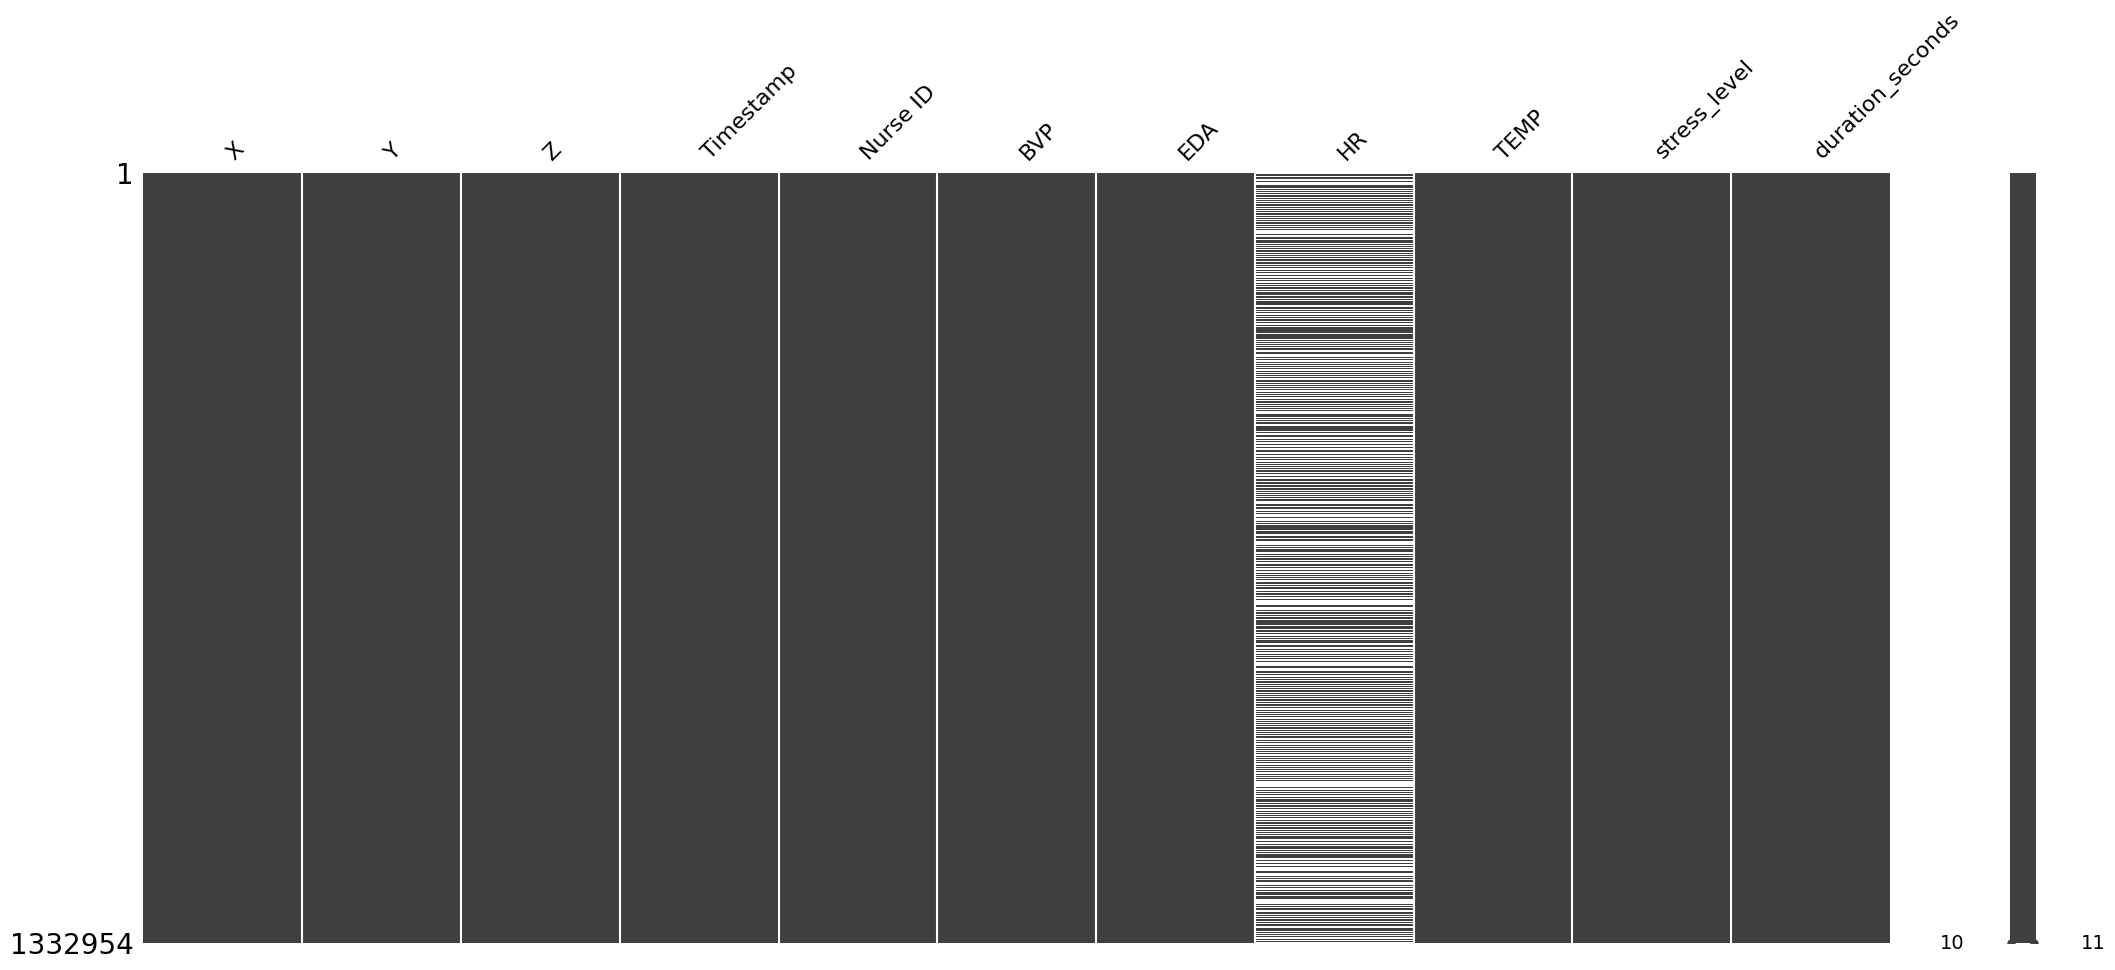

In [ ]:
# visualize missing data patterns
msno.matrix(filtered_df2)

#### Now only the HR(Heart Rate) column contain null entries and need to imputate them since the sampling frequency change has set some null entries which can be filled.

In [82]:
# extract fractional part of the Timestamp
filtered_df2['fraction'] = filtered_df2['Timestamp'] % 1

# check the distribution of fractional values where HR is null
print(filtered_df2[filtered_df2['HR'].isna()]['fraction'].value_counts())


fraction
0.750    333191
0.250    333188
0.000        60
0.500        60
Name: count, dtype: int64


#### The fractions 0.250 and 0.750 is due to sampling frequency change. The remaining 120 records need to be filled as they are missing values and by getting the average HR rate for each (NurseID, stress_level) can fill them.

In [83]:
# iterate through each Nurse ID and fill missing HR values in 0.000 and 0.500 fractions
for nurse_id in filtered_df2['Nurse ID'].unique():
    nurse_df = filtered_df2[filtered_df2['Nurse ID'] == nurse_id]

    # calculate mean HR for each stress_level where fraction is 0.000 or 0.500
    mean_hr_by_stress = nurse_df[(nurse_df['fraction'].isin([0.000, 0.500]))].groupby('stress_level')['HR'].mean()

    # identify rows with missing HR where fraction is 0.000 or 0.500
    missing_hr_mask = (nurse_df['HR'].isna()) & (nurse_df['fraction'].isin([0.000, 0.500]))

    # fill missing HR values using mean HR of corresponding stress_level
    for stress_level, mean_hr in mean_hr_by_stress.items():
        filtered_df2.loc[(filtered_df2['Nurse ID'] == nurse_id) &
                      (filtered_df2['stress_level'] == stress_level) &
                      missing_hr_mask, 'HR'] = mean_hr

In [84]:
# check the updates in the missing HR values
print(filtered_df2[filtered_df2['HR'].isna()]['fraction'].value_counts())

fraction
0.750    333191
0.250    333188
Name: count, dtype: int64


In [85]:
# Reset index of the DataFrame
filtered_df2.reset_index(drop=True, inplace=True)

In [86]:
# iterate through each Nurse ID and fill missing HR values in 0.250 and 0.750 fractions using average of adjacent values
for nurse_id in filtered_df2['Nurse ID'].unique():
    nurse_df = filtered_df2[filtered_df2['Nurse ID'] == nurse_id]

    # loop through each row where HR is missing
    for idx in nurse_df.index:
        if pd.isna(nurse_df.at[idx, 'HR']):
            if nurse_df.at[idx, 'fraction'] in [0.250, 0.750]:
                prev_idx = idx - 1
                next_idx = idx + 1

                if prev_idx in nurse_df.index and next_idx in nurse_df.index:
                    if pd.notna(nurse_df.at[prev_idx, 'HR']) and pd.notna(nurse_df.at[next_idx, 'HR']):
                        avg_hr = (nurse_df.at[prev_idx, 'HR'] + nurse_df.at[next_idx, 'HR']) / 2
                        filtered_df2.at[idx, 'HR'] = avg_hr

In [87]:
filtered_df2.isnull().sum()

X                   0
Y                   0
Z                   0
Timestamp           0
Nurse ID            0
BVP                 0
EDA                 0
HR                  0
TEMP                0
stress_level        0
duration_seconds    0
fraction            0
dtype: int64

<Axes: >

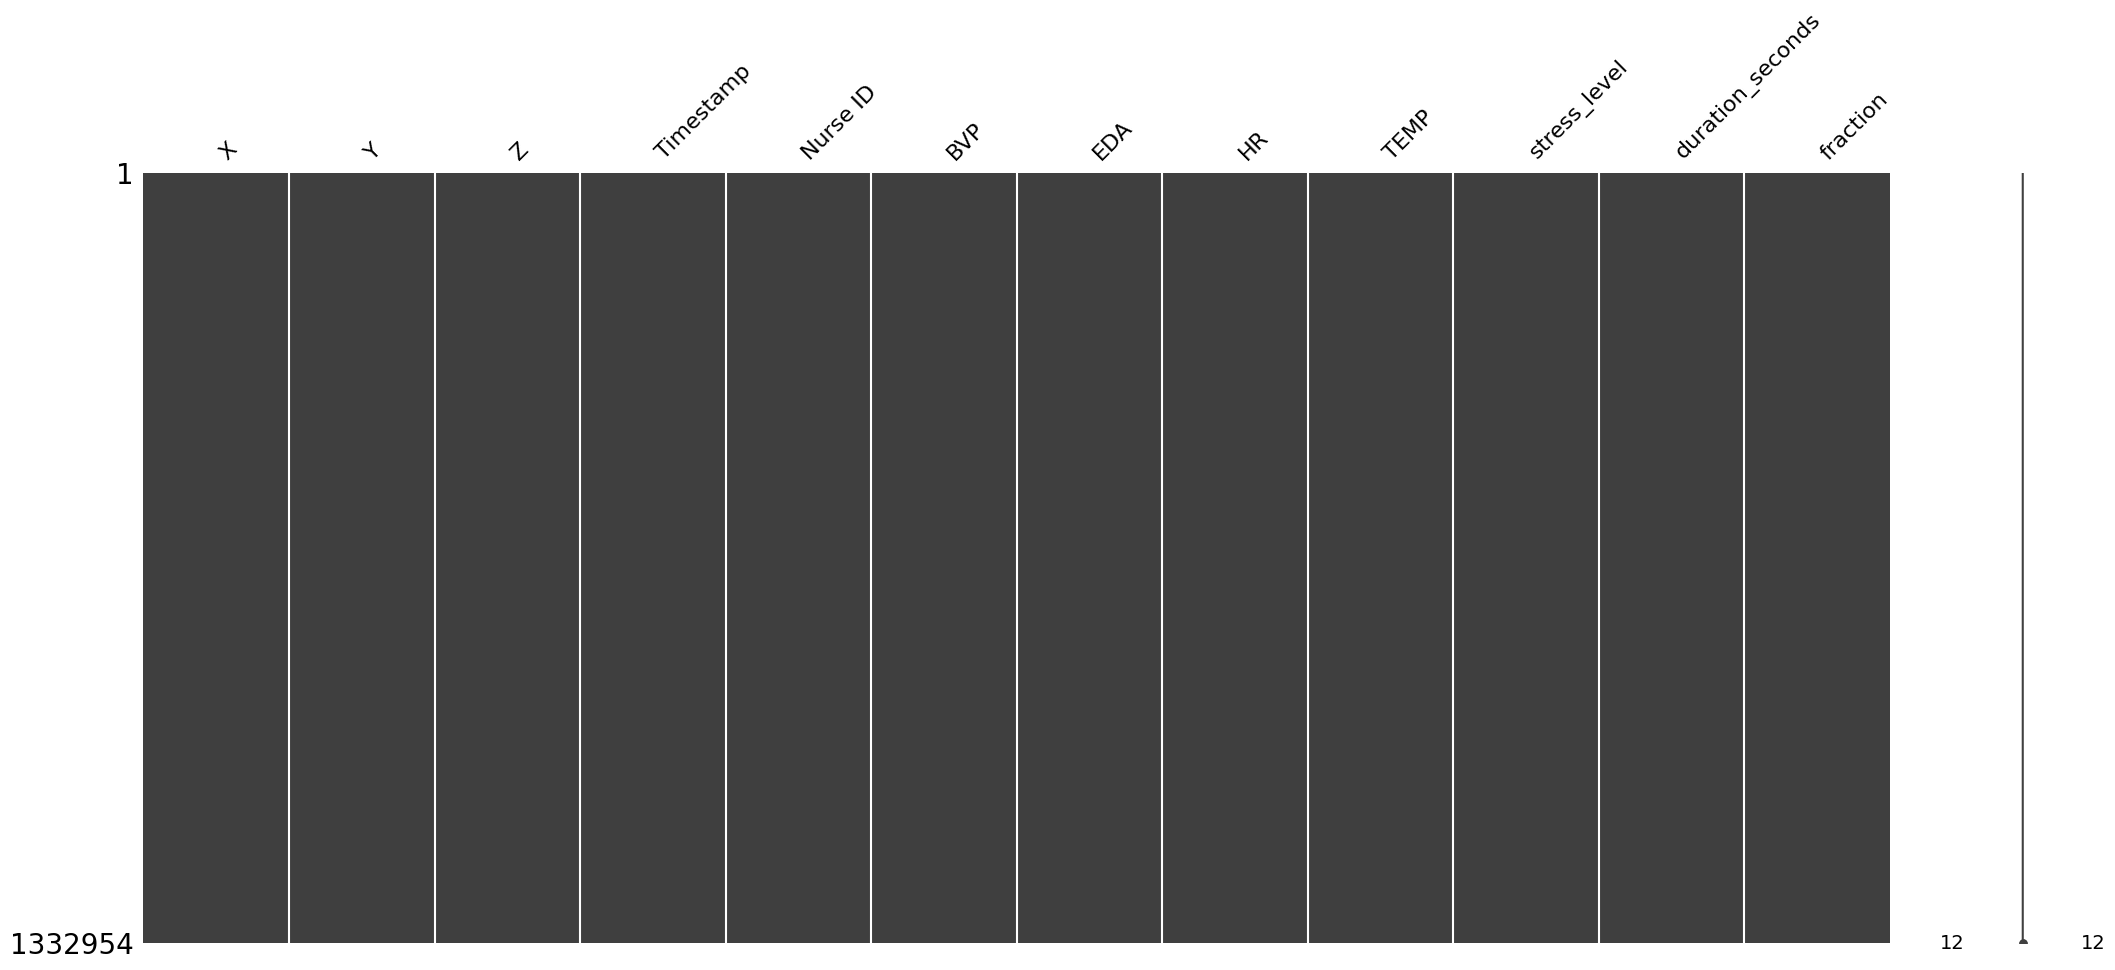

In [88]:
# visualize missing data patterns
msno.matrix(filtered_df2)

##### From above visualization can see there isn't any missing values remaining in the data.

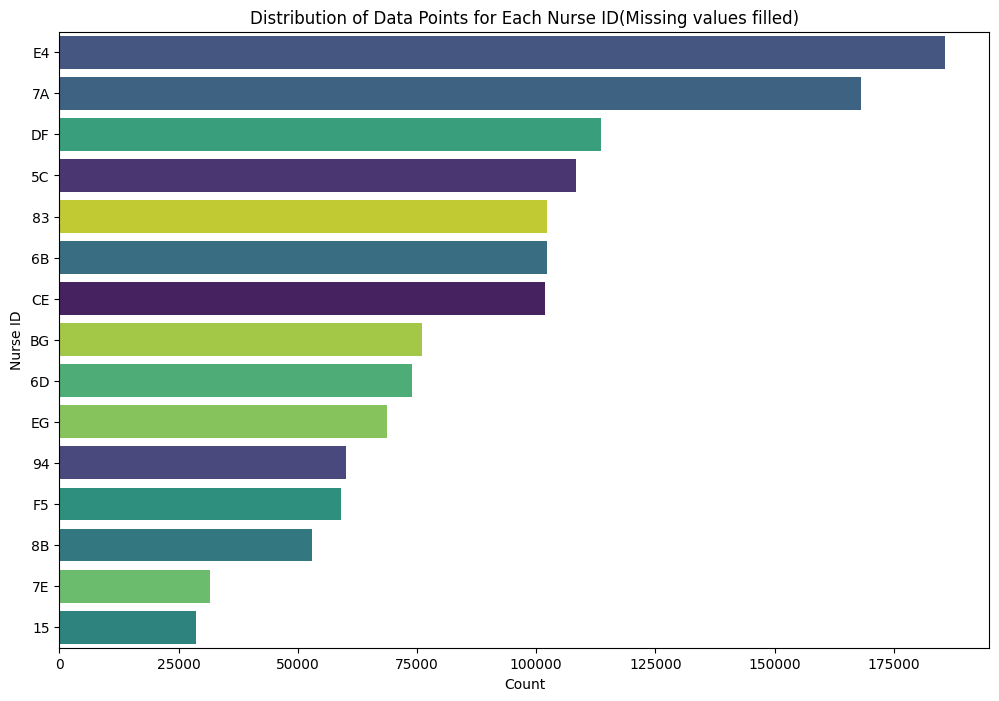

In [90]:

# visualize distribution
plt.figure(figsize=(12, 8))
sns.countplot(y=filtered_df2['Nurse ID'], order=filtered_df2['Nurse ID'].value_counts().index, palette='viridis', hue= filtered_df2['Nurse ID'], legend=False)
plt.title('Distribution of Data Points for Each Nurse ID(Missing values filled)')
plt.xlabel('Count')
plt.ylabel('Nurse ID')
plt.show()

In [91]:
# Save the cleaned data to a new CSV file
filtered_df2.to_csv('cleaned_dataset_part1.csv', index=False)